# iEEG

**Overview**

In this notebook, we will compare data between iEEG contacts inside the hippocapus vs the rest of the brain in terms of band power. We will then extrapolate these band powers across the hippocampus to see if there are systematic differences.

Note that we have already determined which/where channels are in the hippocampus, and preprocessed the iEEG timeseries and converted them to band power values in the `../extras` directory. This also included computing power spectrum densities (PSDs) from preprocessed timeseries data, and computing band powers in the below ranges from PSDs. See there for methodological details

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import nibabel as nib
import hippomaps as hm
import pygeodesic.geodesic as geodesic
from scipy.ndimage import gaussian_filter1d

/export03/data/opt/venv/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [9]:
# define which subjects and surfaces to examine
den='2mm'
hemis = ['L','R']
labels = ['hipp']#,'dentate'] 

# get expected number of vertices and their indices
nV,iV = hm.config.get_nVertices(labels,den) 

# iEEG parameters
freq = 200 #Hz
bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
band_lims = np.array([[0.5,4], [4,8], [8,13], [13,30], [30,80]]) # Hz
sampspace = np.arange(0.5,80,0.5)
dist_threshold = 5 # mm

## 0) Map data to hippocampal surfaces

See `../extras/iEEG_Frauscher.ipynb` and `../extras/iEEG_MICs.ipynb`

## 1) Load the data and examine attributes

Previously we then calculated PSD from each iEEG channel. We then calculated band powers (BP) within 5 bands defined above. Finally, we mapped iEEG channels to hippocampal vertices within 5mm. Thus our hippocampal data is in the shape (number of vertices nV) x (hemispheres 2) x (PSD or number of bands) x (number of channels), where the number of channels is for all channels but data are mostly NaN since most channels are not within 5mm of a hippocmapal vertex.

In [3]:
# load preprocessed bandpower and periogram data
# all data is all clean channels, hipp dat has non-hippocmapal channels NaN'd out

vars_to_load = ['pxx', 'bp', 'hipp_bp', 'hipp_pxx']
t1 = np.load(f'checkpoints/iEEG_Frauscher_dat.npy',allow_pickle=True)
t2 = np.load(f'checkpoints/iEEG_MICs_dat.npy',allow_pickle=True)

In [4]:
PSD = np.concatenate((t1[0], t2[0]),axis=1)
BP = np.concatenate((t1[1], t2[1]),axis=0)
BPhipp = np.concatenate((t1[2],t2[2]),axis=3)
PSDhipp = np.concatenate((t1[3],t2[3]),axis=3)

In [5]:
BPhipp.shape

(419, 2, 5, 4279)

In [6]:
PSDhipp.shape

(419, 2, 159, 4279)

**Spatial distribution of hippocampal-adjacent channels**

In [7]:
# find which channels are actually close to any hippocampal vertex

nL = len(np.where(np.any(~np.isnan(BPhipp[:,0,0,:]),axis=0))[0])
nR = len(np.where(np.any(~np.isnan(BPhipp[:,1,0,:]),axis=0))[0])

print('number of L hemis: ' + str(nL))
print('number of R hemis: ' + str(nR))

/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


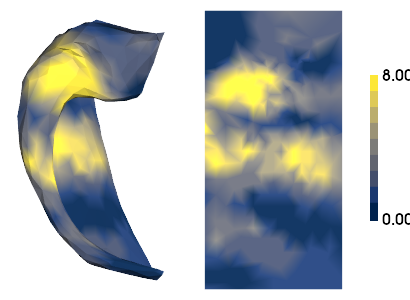

In [10]:
# sum how many channels are close to each vertex
hipp_dat_count = np.sum(~np.isnan(BPhipp),axis=(1,3))[:,0]
hm.plotting.surfplot_canonical_foldunfold(hipp_dat_count, den='2mm', hemis=['L'], labels=labels, unfoldAPrescale=True, tighten_cwindow=True, cmap='cividis', share='row', color_bar='right', embed_nb=True)

**Compare PSDs from the hippocampus to all channels to ensure they are comparable**

(0.4, 100)

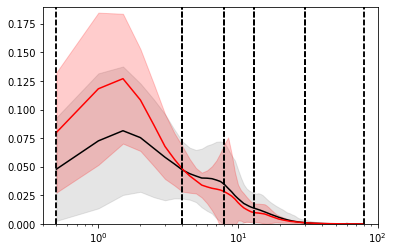

In [11]:
y = np.exp(np.nanmean(np.log(PSD),axis=1))
err = np.nanstd(PSD,axis=1)
plt.plot(sampspace,y,'k')
plt.ylim(0,.19)
plt.fill_between(sampspace, y-err, y+err, alpha=0.2, color='gray')
plt.vlines(band_lims.flatten(),plt.gca().get_ylim()[0],plt.gca().get_ylim()[1],colors='k',linestyles='--')
plt.xscale('log')
plt.xlim(0.4,100)

y = np.exp(np.nanmean(np.log(PSDhipp),axis=(0,1,3)))
err = np.nanstd(PSDhipp,axis=(0,1,3))
plt.plot(sampspace,y,'r')
plt.ylim(0,.19)
plt.fill_between(sampspace, y-err, y+err, alpha=0.2, color='r')
plt.vlines(band_lims.flatten(),plt.gca().get_ylim()[0],plt.gca().get_ylim()[1],colors='k',linestyles='--')
plt.xscale('log')
plt.xlim(0.4,100)

**Compare BPs from the hippocampus to all channels to ensure they are comparable**

Plot a distribution of band powers from all channels, and from the subset of hippocampal channels

Periodic data is typically lognormal distributed, so we apply logarithmic scaling

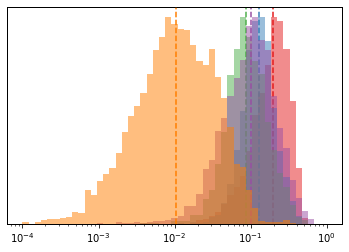

In [13]:
# all channels

colormap = pl.cm.Set1(range(10))
l=['delta', 'theta', 'alpha', 'beta', 'gamma']
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.yaxis.set_visible(False)
ax = [ax]
n=0
cbins = [] # number of channels in each bin
for b in range(5):
    ax = ax + [ax[0].twinx()] # nake a new axis for each distribution so they don't share a y-axis and thus fill the whole plot
    dat = BP[:,b]
    plt.axvline(x=np.nanmedian(dat), color=colormap[n], linestyle='dashed')
    cbins.append(ax[n+1].hist(dat,bins=np.logspace(np.log10(1e-4),np.log10(1), 50), linestyle=None, alpha=0.5, 
               color=colormap[b], label=l[b]))
    ax[n+1].yaxis.set_visible(False)
    n=n+1

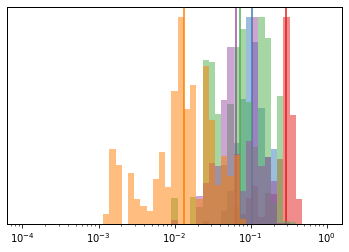

In [14]:
# hippocampal channels

colormap = pl.cm.Set1(range(10))
l=['delta', 'theta', 'alpha', 'beta', 'gamma']
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.yaxis.set_visible(False)
ax = [ax]
n=0
hippcbins = [] # number of channels in each bin
for b in range(5):
    ax = ax + [ax[0].twinx()] # nake a new axis for each distribution so they don't share a y-axis and thus fill the whole plot
    dat = BPhipp[:,:,b,:].flatten()
    plt.axvline(x=np.nanmedian(dat), color=colormap[n], linestyle='solid')
    hippcbins.append(ax[n+1].hist(dat,bins=np.logspace(np.log10(1e-4),np.log10(1), 50), linestyle=None, alpha=0.5, 
               color=colormap[b], label=l[b]))
    ax[n+1].yaxis.set_visible(False)
    n=n+1

Nicer ridge plot, showing hippocampal data in colour and all data in grey behind

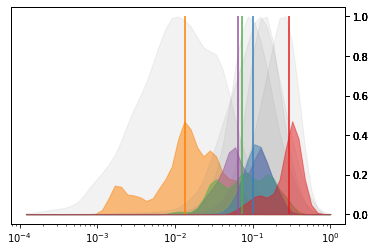

In [15]:
colormap = pl.cm.Set1(range(10))
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.yaxis.set_visible(False)
ax = [ax]
sigma = 1
n=0
for b in reversed(range(5)):
    ax = ax + [ax[0].twinx()]
    dat = BP[:,b]
    #ax[n+1].vlines(np.nanmedian(dat),0,1, color='gray', linestyle='dashed')
    plt.fill_between(cbins[b][1][1:],gaussian_filter1d(cbins[b][0],sigma), color='gray', alpha=0.1)
    ax[n+1].yaxis.set_visible(False)
    n=n+1
n=0
for b in reversed(range(5)):
    ax = ax + [ax[0].twinx()]
    dat = BPhipp[:,:,b,:].flatten()
    plt.vlines(np.nanmedian(dat),0,1, color=colormap[b], linestyle='solid')
    ax[n+1].fill_between(hippcbins[b][1][1:],gaussian_filter1d(hippcbins[b][0],sigma), color=colormap[b], alpha=0.5)
    #ax[n+1].hist(dat,bins=np.logspace(np.log10(1e-4),np.log10(1), 50), linestyle=None, alpha=0.5, 
    #           color=colormap[b], label=l[b]);
    ax[n+1].yaxis.set_visible(False)
    n=n+1

## 2) Spatial extrapolation
We can see that simply averaging over all channels doesn't give a good idea of the spatial distribution of band power, since so much data is missing. Thus, we will extrapolate each channel over the whole hippocampus and then use the distance from the channel as a weighting when performing weighted averaging across channels. See `../extras` for an example visualization.

In [16]:
surfL = nib.load('/export03/data/opt/hippunfold-templateflow/tpl-MNI152NLin2009cSym/tpl-MNI152NLin2009cSym_hemi-L_space-T1w_den-2mm_label-hipp_midthickness.surf.gii')
surfR = nib.load('/export03/data/opt/hippunfold-templateflow/tpl-MNI152NLin2009cSym/tpl-MNI152NLin2009cSym_hemi-R_space-T1w_den-2mm_label-hipp_midthickness.surf.gii')
vertices = np.stack((surfL.get_arrays_from_intent('NIFTI_INTENT_POINTSET')[0].data,surfR.get_arrays_from_intent('NIFTI_INTENT_POINTSET')[0].data),axis=2)
faces = surfL.get_arrays_from_intent('NIFTI_INTENT_TRIANGLE')[0].data

In [18]:
weights = np.zeros((BPhipp.shape[0],2,BPhipp.shape[3]))
BPhipp_extrapolated = np.zeros([BPhipp.shape[0],5])
PSDhipp_extrapolated = np.zeros([BPhipp.shape[0],len(PSD)])

for h,hemi in enumerate(hemis):
    for l,label in enumerate(labels):
        for c in range(BPhipp.shape[3]):
            dat = BPhipp[:,h,0,c]
            mask = ~np.isnan(dat[iV[l]])
            if np.any(mask):
                geoalg = geodesic.PyGeodesicAlgorithmExact(vertices[:,:,h], faces)
                sd,_ = geoalg.geodesicDistances(np.where(mask)[0], None)
                sd = sd**2
                weights[iV[l],h,c] = 1 - (sd/np.max(sd))
                
totweights = np.nansum(weights, axis=(1,2))
for v in range(weights.shape[0]):
    for h in range(2):
        for c in range(BPhipp.shape[3]):
            w = weights[v,h,c] / totweights[v]
            if w>0:
                BPhipp_extrapolated[v,:] += np.nanmean(BPhipp[:,h,:,c],axis=0) * w
                PSDhipp_extrapolated[v,:] += np.nanmean(PSDhipp[:,h,:,c],axis=0) * w

/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


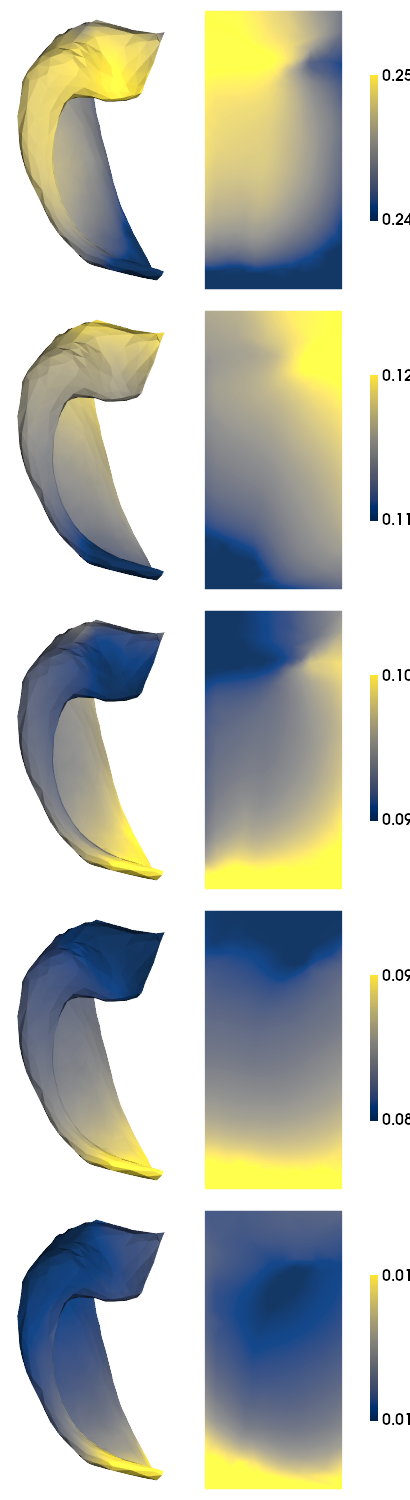

In [19]:
hm.plotting.surfplot_canonical_foldunfold(BPhipp_extrapolated, den=den, hemis=['L'], labels=labels, unfoldAPrescale=True, tighten_cwindow=True, cmap='cividis', share='row', color_bar='right', embed_nb=True)

## 2) Summarize data according to primary gradients

Dimensionality reduction allows us to summarize many maps as primary components, or Gradients. Here we will use BrainSpace to compute nonlinear Gradients using diffusion map embedding. Briefly, this typically consists of computing an affinity matrix (e.g. a correlation between all maps) and then grouping them into a few consistent patterns (Gradients). This allows us to use all aspects of the PSD rather than simplifying it into band powers. 

In [20]:
from brainspace.gradient import GradientMaps

# gradient decomposition of power spectrum densities across hippocampal vertices
GMpsd = GradientMaps(n_components=5, kernel='pearson') # Here we apply Pearson's R to compute affinity matrices to match the examples of structural MPC gradients
GMpsd.fit(PSDhipp_extrapolated, sparsity=0.1)

GradientMaps(kernel='pearson', n_components=5)

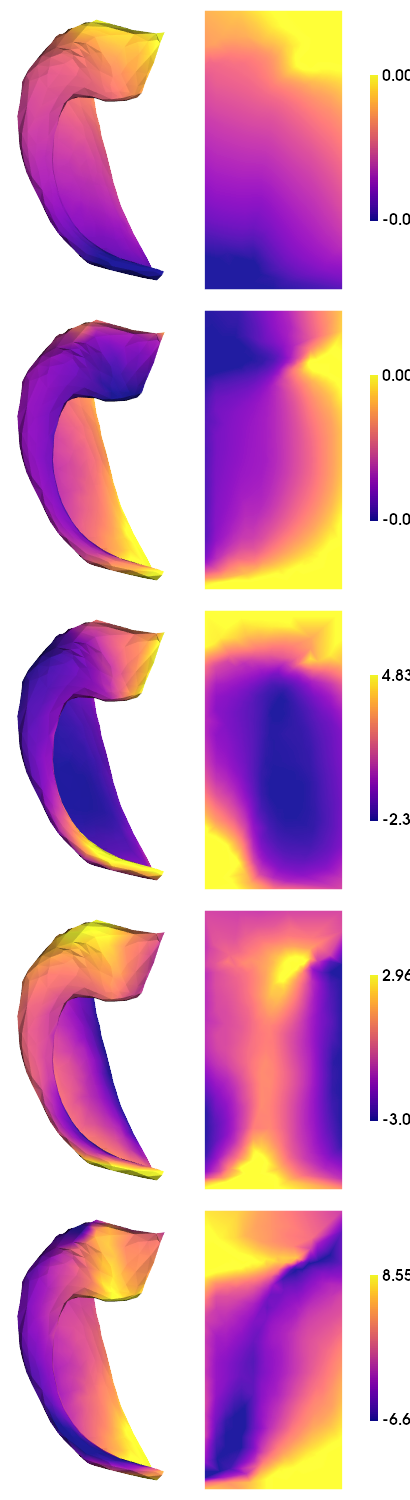

In [21]:
# As above, we can make a nice plot for each of the resulting gradients
hm.plotting.surfplot_canonical_foldunfold(GMpsd.gradients_, den=den, hemis=['L'], labels=labels, unfoldAPrescale=True, tighten_cwindow=True, cmap='plasma', share='row', color_bar='right', embed_nb=True)

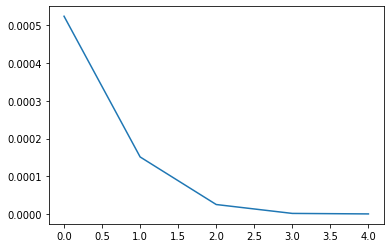

In [22]:
# we can also see the lambda value (or eigenvalue) for each gradient
plt.plot(GMpsd.lambdas_)

In [23]:
# convert into a percentage of explained variance
GMpsd.lambdas_/np.sum(GMpsd.lambdas_)

array([7.45478525e-01, 2.15285654e-01, 3.60368766e-02, 2.54641240e-03,
       6.52531597e-04])

To help contextualize how these gradients relate to PSDs, we can plot the PSDs from only to top and the bottom 10% vertices for each gradient.

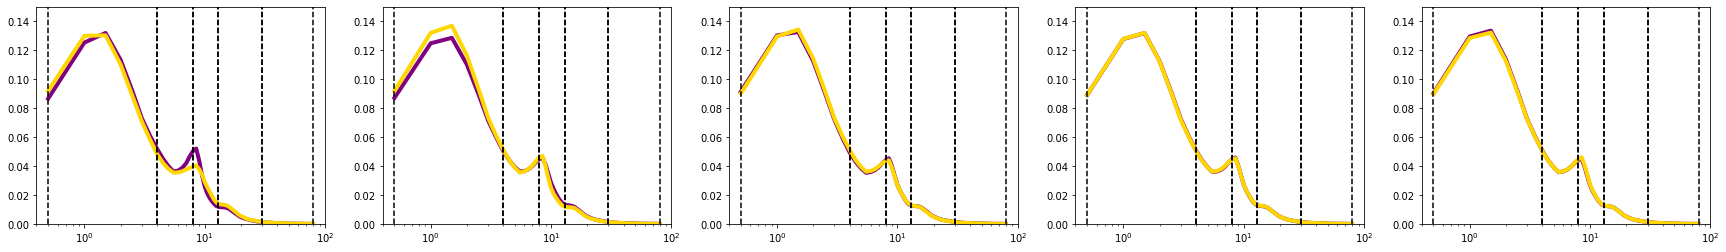

In [25]:
# compare top to bottom
n_components=5
fig, ax = plt.subplots(nrows=1, ncols=n_components, figsize=(6*n_components,4))

for c in range(n_components):

    nvertsplit = int(nV*.1)

    bot = np.argpartition(GMpsd.gradients_[:,c],nvertsplit)[:nvertsplit]
    top = np.argpartition(GMpsd.gradients_[:,c],-nvertsplit)[-nvertsplit:]

    ax[c].plot(sampspace,np.mean(PSDhipp_extrapolated[top,:],axis=0),color='purple', linewidth=4)
    ax[c].plot(sampspace,np.mean(PSDhipp_extrapolated[bot,:],axis=0),color='gold', linewidth=4)
    #ax[c].set_yscale('log')
    ax[c].set_xscale('log')
    ax[c].set_xlim(0.4,100)
    ax[c].set_ylim(0,.15)
    ax[c].vlines(band_lims.flatten(),ax[c].get_ylim()[0],ax[c].get_ylim()[1],colors='k',linestyles='--')

**save**

In [ ]:
# save a copy of the 2D map
!mkdir -p ../maps/HippoMaps-initializationMaps/Dataset-MICs+Frauscher/
for b,band in enumerate(bands):
    cdat = BPhipp_extrapolated[:,b]
    data_array = nib.gifti.GiftiDataArray(data=cdat)
    image = nib.gifti.GiftiImage()
    image.add_gifti_data_array(data_array)
    nib.save(image, f'../maps/HippoMaps-initializationMaps/Dataset-MICs+Frauscher/iEEG-BandPower-{band}_average-{nL+nR}_hemi-mix_den-{den}_label-{label}.shape.gii')

In [ ]:
# save a copy of the 2D map
!mkdir -p ../maps/HippoMaps-initializationMaps/Dataset-MICs+Frauscher/
for l,label in enumerate(labels):    
    cdat = bpgm.gradients_
    data_array = nib.gifti.GiftiDataArray(data=cdat)
    image = nib.gifti.GiftiImage()
    image.add_gifti_data_array(data_array)
    nib.save(image, f'../maps/HippoMaps-initializationMaps/Dataset-MICs+Frauscher/iEEG-BandPower-G1to5_average-{nL+nR}_hemi-mix_den-{den}_label-{label}.shape.gii')